In [34]:
# https://www.kaggle.com/code/muhammadfaizan65/machine-failure-prediction-eda-modeling

In [35]:
import functions
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA

In [36]:
data, X_train, X_test, y_train, y_test, scaler, *_= functions.data_split(path='Data/data_cleaned.csv')

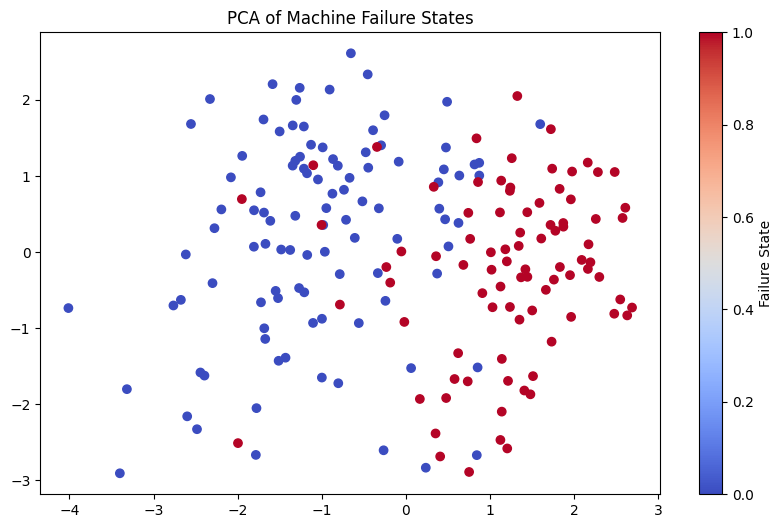

In [37]:
# Dimensionality reduction using PCA
pca = PCA() # n_components=2
X_pca = pca.fit_transform(X_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='coolwarm', marker='o')
plt.title('PCA of Machine Failure States')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
plt.colorbar(label='Failure State')
plt.show()

In [38]:
# Model Training and Hyperparameter Tuning
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(probability=True)
}

params = {
    'RandomForest': {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 10, 20, 50]},
    'GradientBoosting': {'n_estimators': [10, 50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]},
    'LogisticRegression': {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20]},
    'SVM': {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20], 'kernel': ['linear', 'rbf']}
}

In [39]:
best_models = {}
best_accuracy = 0
best_model_name = ''
best_model = None

for model_name in models.keys():
    grid = GridSearchCV(models[model_name], params[model_name], cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best_models[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        best_model = grid.best_estimator_

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for RandomForest: {'max_depth': 10, 'n_estimators': 50}
Accuracy for RandomForest: 0.8783068783068783
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for GradientBoosting: {'learning_rate': 0.05, 'n_estimators': 100}
Accuracy for GradientBoosting: 0.8888888888888888
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for LogisticRegression: {'C': 0.01}
Accuracy for LogisticRegression: 0.8783068783068783
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for SVM: {'C': 0.05, 'kernel': 'linear'}
Accuracy for SVM: 0.873015873015873

Best model: GradientBoosting with accuracy: 0.8888888888888888


In [20]:
# Evaluation of the best model
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

In [21]:
# Plot confusion matrix
fig = px.imshow(cm, text_auto=True, color_continuous_scale='Blues', template='plotly_dark')
fig.update_layout(title_text=f'Confusion Matrix for {best_model_name}', title_font=dict(size=25), title_x=0.5)
fig.show()

In [9]:
# Print classification report
report_df = pd.DataFrame(report).transpose()
print(f'Classification Report for {best_model_name}')
print(report_df)

Classification Report for GradientBoosting
              precision    recall  f1-score     support
0              0.900990  0.892157  0.896552  102.000000
1              0.875000  0.885057  0.880000   87.000000
accuracy       0.888889  0.888889  0.888889    0.888889
macro avg      0.887995  0.888607  0.888276  189.000000
weighted avg   0.889026  0.888889  0.888933  189.000000


In [10]:
# ROC Curve and AUC for the best model
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{best_model_name} (AUC = {roc_auc:.2f})', line=dict(width=2)))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash', color='gray'), name='Random'))
fig.update_layout(title_text='Receiver Operating Characteristic', title_font=dict(size=25), xaxis_title='False Positive Rate', yaxis_title='True Positive Rate', template='plotly_dark')
fig.show()